In [1]:
import pickle

with open('resultslist.pickle', 'rb') as f:
    results = pickle.load(f)
    
with open('dates.pickle', 'rb') as f:
    dates = pickle.load(f)    

In [2]:
import dateutil.parser

def catch(date):
    try:
        return dateutil.parser.parse(date)
    except Exception as e:
        print(e)
        return 'Date'

formatted_dates = [catch(date) for date in dates]

Unknown string format: Date
Unknown string format: Date
Unknown string format: Date
Unknown string format: Date
Unknown string format: Leaders in subclassifications
Stage Points KOM Youth Teams
1 SAGAN Peter Sport Vlaanderen - Baloise
2 KÜNG Stefan BMC Racing Team
3 SAGAN Peter BMC Racing Team
4 SAGAN Peter BMC Racing Team
5 SAGAN Peter Quick-Step Floors
6 SAGAN Peter Lotto Soudal
7 SAGAN Peter Trek - Segafredo
Unknown string format: Leaders in subclassifications
Stage Points KOM Youth Teams
1 VAN VLEUTEN Annemiek MACKAIJ Floortje Canyon//SRAM Racing
2 VAN DIJK Ellen VAN GOGH Natalie MACKAIJ Floortje Canyon//SRAM Racing
3 VAN DIJK Ellen VAN GOGH Natalie SWINKELS Karlijn Canyon//SRAM Racing
4 BRENNAUER Lisa VAN GOGH Natalie SWINKELS Karlijn Canyon//SRAM Racing
5 VAN VLEUTEN Annemiek KOSTER Anouska DE JONG Demi Boels - Dolmans Cycling Team
6 BRENNAUER Lisa RYAN Alexis DE JONG Demi Boels - Dolmans Cycling Team
Unknown string format: Leaders in subclassifications
Stage Points KOM Youth Tea

In [3]:
import pandas as pd

race_clusters = pd.read_csv('clustersNOV2023.csv')

old_clusters = pd.read_csv('clustered_races.csv')

race_clusters = old_clusters.merge(race_clusters, left_on = 'name2', right_on = 'Race Name', how = 'left')

In [4]:
race_clusters

,Unnamed: 0,name2,cluster_labels,Race Name,Constrained,KmeansClust
0,0,2017 4 Jours de Dunkerque,3,2017 4 Jours de Dunkerque,1.0,3.0
1,1,2017 99a Coppa Bernocchi - 42o GP BPM,5,2017 99a Coppa Bernocchi - 42o GP BPM,2.0,2.0
2,2,2017 Abu Dhabi Tour Stage 1,3,2017 Abu Dhabi Tour Stage 1,1.0,7.0
3,3,2017 Abu Dhabi Tour Stage 2,0,2017 Abu Dhabi Tour Stage 2,4.0,3.0
4,4,2017 Abu Dhabi Tour Stage 3,5,2017 Abu Dhabi Tour Stage 3,0.0,4.0
...,...,...,...,...,...,...
6238,6238,2022 ZLM Tour Stage 1,1,2022 ZLM Tour Stage 1,5.0,3.0
6239,6239,2022 ZLM Tour Stage 2,6,2022 ZLM Tour Stage 2,1.0,3.0
6240,6240,2022 ZLM Tour Stage 3,6,2022 ZLM Tour Stage 3,1.0,5.0
6241,6241,2022 ZLM Tour Stage 4,3,2022 ZLM Tour Stage 4,1.0,7.0


In [5]:
def name_adjustment(test_df):
    try:
        test_df['Team'] = np.where(test_df['Team'].isna(), '', test_df['Team'])
        test_df['ActualName'] = [a.replace(b, '').strip() for a, b in zip(test_df['Rider'], test_df['Team'])]
        return(test_df)
    except:
        try:
            test_df['ActualName'] =test_df['Team']
            test_df['Time'] = np.where(test_df['Time'].isna(), test_df['Time'],  test_df['Team']) 
            test_df['Team'] = test_df['Time'].fillna(method="pad")
            test_df['Pos.'] = test_df['Pos.'].fillna(method="pad")
            test_df = test_df[test_df['Time'].isna()]
            return(test_df)
        except:
            return('Bad DataFrame')

## Team methode: best rider = performance

In [6]:
from itertools import compress
import numpy as np
from trueskill import Rating, rate

ratings_list = []

for k in range(9):

    fil = [date!='Date' for date in formatted_dates]
    cluster_fil = np.where(race_clusters['KmeansClust']==k, True, False)[0:len(fil)]
    total_fil = [cluster_fil[i] and fil[i] for i in range(len(cluster_fil))]

    filtered_results = list(compress(results, total_fil))
    filtered_dates = list(compress(formatted_dates, total_fil))
    
    print(len(filtered_results))
    
    filtered_results3 = [name_adjustment(df) for df in filtered_results]
    
    filtered_results4 = []
    filtered_dates2 = []
    
    for i in range(len(filtered_results3)):
        df = filtered_results3[i]
        #print(i)
        try:
            if df=='Bad DataFrame':
                print(filtered_results[i])
        except:
            filtered_results4.append(filtered_results3[i])
            filtered_dates2.append(filtered_dates[i])
    
    unique_ids = pd.concat(filtered_results4)['ActualName'].unique()
    rating_dict = dict()
    for i in unique_ids:
        rating_dict[i] = Rating()

    ordered_results =  [x for _, _, x in sorted(zip(filtered_dates2, range(len(filtered_dates2)), filtered_results4))]
    teller = 0
    for race_result in ordered_results:
        print(teller)
        teller+=1
        if race_result.shape[0]==0:
            print('empty results')
        else:
            if len(race_result['Team'].unique())>1:
                g = race_result.groupby('Team')['ActualName'].unique()
                if 'Rnk' in race_result.columns:    
                    race_result['Pos.'] = race_result.index
                race_result['Pos.'] = race_result['Pos.'].astype(int)
                ranks = race_result.groupby('Team')['Pos.'].min()

                team_vector = []
                for team_samenstelling in g:
                    team = []
                    for rider in team_samenstelling:
                        team.append(rating_dict[rider])
                    team_vector.append(team)
                updated_ratings = rate(team_vector, ranks.values)

                for i in range(len(updated_ratings)):
                    new_team_ratings = updated_ratings[i]
                    team_name = g[i]
                    for j in range(len(new_team_ratings)):
                        new_rating = new_team_ratings[j]
                        rating_dict[team_name[j]] = new_rating
                    
    rating_df = pd.DataFrame.from_dict(rating_dict).transpose()
    rating_df.columns = ['Mu', 'Sigma']

    ratings_list.append(rating_df.sort_values(by=['Mu'], ascending = False))

1082
     #                          Rider Name (Country) Team           Result
0    1              Marta Bastianelli (Ita) Alé Cipollini          1:17:38
1    2         Katie Archibald (GBr) Team WNT Pro Cycling   Row 1 - Cell 2
2    3               Gracie Elvin (Aus) Orica Scott Women   Row 2 - Cell 2
3    4    Christina Siggaard (Den) Team Veloconcept Women   Row 3 - Cell 2
4    5             Rasa Leleivyte (Ltu) Aromitalia Vaiano   Row 4 - Cell 2
5    6       Annemiek Van Vleuten (Ned) Orica Scott Women   Row 5 - Cell 2
6    7  Eva Buurman (Ned) Parkhotel Valkenburg-Destil ...   Row 6 - Cell 2
7    8  Ashleigh Moolman-Pasio (RSA) Cervelo Bigla Pro...   Row 7 - Cell 2
8    9           Michela Balducci (Ita) Giusfredi Bianchi   Row 8 - Cell 2
9   10                      Alicia Gonzalez (Spa) Lointek   Row 9 - Cell 2
10  11      Camilla Pedersen (Den) Team Veloconcept Women  Row 10 - Cell 2
11  12                 Soraya Paladin (Ita) Alé Cipollini  Row 11 - Cell 2
12  13  Eri Yonamine

C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
empty results
195
empty results
196
197
198
199
200
201
202
203
204
205
206
207
208


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

975
976
977
978
979
980
981
982
983


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
empty results
1009
empty results
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
empty results
1047
1048
1049
1050
1051
1052
1053
1054


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
empty results
1078
empty results
1079
empty results


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


657
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
empty results
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
empty results
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


902
903
904
905
empty results
906
empty results
686
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
empty results
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
empty results
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
3

C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


671
   #           Rider Birthplace
0  1     BULUT Samet      Bursa
1  2       UZUN Emir      Bursa
2  3  YILDIZ Mustafa      Bursa
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
empty results
124
empty results
125
empty results
126
empty results
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
empty results
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
empty results
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
empty results
586
    #                          Rider Name (Country) Team          Result
0   1              Amanda Spratt (Aus) Orica Scott Women         2:28:12
1   2       Ane Santesteban Gonzalez (Spa) Alé Cipollini         0:00:02
2   3              Marta Bastianelli (Ita) Alé Cipollini         0:00:26
3   4               Gracie Elvin (Aus) Orica Scott Women  Row 3 - Cell 2
4   5  Eva Buurman (Ned) Parkhotel Valkenburg-Destil ...  Row 4 - Cell 2
5   6         Katie Archibald (GBr) Team WNT Pro Cycling  Row 5 - Cell 2
6   7  Ashleigh Moolman-Pasio (RSA) Cervelo Bigla Pro...  Row 6 - Cell 2
7   8             Rasa Leleivyte (Ltu) Aromitalia Vaiano  Row 7 - Cell 2
8   9         Abigail Van Twisk (GBr) Drops Cycling Team  Row 8 - Cell 2
9  10  Ganna Solovei (Ukr) Parkhotel Valkenburg-Desti...  Row 9 - Cell 2
    #                          Rider Name (Country) Team          Result
0 

C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
empty results
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
38

C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2689096150.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
empty results
580
581
582
583


In [7]:
ratings_list

[                           Mu     Sigma
 AGUILA Julyn Renee  69.808788  6.477057
 BERNS Mats          68.253950  5.334911
 TUFT Svein          62.842859  2.448981
 DENNIS Rohan        58.377252  1.774211
 SCHARRE Stef        57.838089  6.079972
 ...                       ...       ...
 DAUGE Lucas        -41.380353  7.256854
 SOUTON Julien      -43.979783  6.215693
 STRINDIN Joachim   -44.838402  8.032674
 FIERLA Ondřej      -51.572818  7.096382
 KIRILLOVA Polina   -52.765447  6.369233
 
 [18486 rows x 2 columns],
                            Mu     Sigma
 MILTIADIS Andreas   67.866397  3.491949
 SUESCA Marco Tulio  61.606599  6.565760
 NOCENTINI Rinaldo   61.452046  3.349878
 KOREVAAR Jeanne     60.794833  3.650595
 LOHINSKÝ Filip      59.763703  5.198150
 ...                       ...       ...
 NEGRENTE Marco     -29.670423  8.199643
 MARKOV Dmitrii     -34.021773  8.149413
 CONTI Giacomo      -38.728489  8.195393
 CERVELLERA Andrea  -38.998666  7.476769
 RUIJMGAARD Yentl   -47.9853

## Team methode: mean = performance

In [8]:
from itertools import compress
import numpy as np
from trueskill import Rating, rate

ratings_list_mean = []

for k in range(9):

    fil = [date!='Date' for date in formatted_dates]
    cluster_fil = np.where(race_clusters['KmeansClust']==k, True, False)[0:len(fil)]
    total_fil = [cluster_fil[i] and fil[i] for i in range(len(cluster_fil))]

    filtered_results = list(compress(results, total_fil))
    filtered_dates = list(compress(formatted_dates, total_fil))
    
    print(len(filtered_results))
    
    filtered_results3 = [name_adjustment(df) for df in filtered_results]
    
    filtered_results4 = []
    filtered_dates2 = []
    
    for i in range(len(filtered_results3)):
        df = filtered_results3[i]
        #print(i)
        try:
            if df=='Bad DataFrame':
                print(filtered_results[i])
        except:
            filtered_results4.append(filtered_results3[i])
            filtered_dates2.append(filtered_dates[i])
    
    unique_ids = pd.concat(filtered_results4)['ActualName'].unique()
    rating_dict = dict()
    for i in unique_ids:
        rating_dict[i] = Rating()

    ordered_results =  [x for _, _, x in sorted(zip(filtered_dates2, range(len(filtered_dates2)), filtered_results4))]
    teller = 0
    for race_result in ordered_results:
        print(teller)
        teller+=1
        if race_result.shape[0]==0:
            print('empty results')
        else:
            if len(race_result['Team'].unique())>1:
                g = race_result.groupby('Team')['ActualName'].unique()
                if 'Rnk' in race_result.columns:    
                    race_result['Pos.'] = race_result.index
                race_result['Pos.'] = race_result['Pos.'].astype(int)
                ranks = race_result.groupby('Team')['Pos.'].mean()

                team_vector = []
                for team_samenstelling in g:
                    team = []
                    for rider in team_samenstelling:
                        team.append(rating_dict[rider])
                    team_vector.append(team)
                updated_ratings = rate(team_vector, ranks.values)

                for i in range(len(updated_ratings)):
                    new_team_ratings = updated_ratings[i]
                    team_name = g[i]
                    for j in range(len(new_team_ratings)):
                        new_rating = new_team_ratings[j]
                        rating_dict[team_name[j]] = new_rating
                    
    rating_df = pd.DataFrame.from_dict(rating_dict).transpose()
    rating_df.columns = ['Mu', 'Sigma']

    ratings_list_mean.append(rating_df.sort_values(by=['Mu'], ascending = False))

1082
     #                          Rider Name (Country) Team           Result
0    1              Marta Bastianelli (Ita) Alé Cipollini          1:17:38
1    2         Katie Archibald (GBr) Team WNT Pro Cycling   Row 1 - Cell 2
2    3               Gracie Elvin (Aus) Orica Scott Women   Row 2 - Cell 2
3    4    Christina Siggaard (Den) Team Veloconcept Women   Row 3 - Cell 2
4    5             Rasa Leleivyte (Ltu) Aromitalia Vaiano   Row 4 - Cell 2
5    6       Annemiek Van Vleuten (Ned) Orica Scott Women   Row 5 - Cell 2
6    7  Eva Buurman (Ned) Parkhotel Valkenburg-Destil ...   Row 6 - Cell 2
7    8  Ashleigh Moolman-Pasio (RSA) Cervelo Bigla Pro...   Row 7 - Cell 2
8    9           Michela Balducci (Ita) Giusfredi Bianchi   Row 8 - Cell 2
9   10                      Alicia Gonzalez (Spa) Lointek   Row 9 - Cell 2
10  11      Camilla Pedersen (Den) Team Veloconcept Women  Row 10 - Cell 2
11  12                 Soraya Paladin (Ita) Alé Cipollini  Row 11 - Cell 2
12  13  Eri Yonamine

C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


77
78
79
80
81
82
83
84
85
86
87


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

192
193
194
empty results
195
empty results
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
empty results
1009
empty results
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


1046
empty results
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
empty results
1078
empty results
1079
empty results


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


657
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
empty results
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
empty results
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


686
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
empty results
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
empty results
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303

C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


671
   #           Rider Birthplace
0  1     BULUT Samet      Bursa
1  2       UZUN Emir      Bursa
2  3  YILDIZ Mustafa      Bursa
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
empty results
124
empty results
125
empty results
126
empty results
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
empty results
167
168
169
170
171
172
173
174
175
176
177
178
179
180


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
empty results
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
empty results
586
    #                          Rider Name (Country) Team          Result
0   1              Amanda Spratt (Aus) Orica Scott Women         2:28:12
1   2       Ane Santesteban Gonzalez (Spa) Alé Cipollini         0:00:02
2   3              Marta Bastianelli (Ita) Alé Cipollini         0:00:26
3   4               Gracie Elvin (Aus) Orica Scott Women  Row 3 - Cell 2
4   5  Eva Buurman (Ned) Parkhotel Valkenburg-Destil ...  Row 4 - Cell 2
5   6         Katie Archibald (GBr) Team WNT Pro Cycling  Row 5 - Cell 2
6   7  Ashleigh Moolman-Pasio (RSA) Cervelo Bigla Pro...  Row 6 - Cell 2
7   8             Rasa Leleivyte (Ltu) Aromitalia Vaiano  Row 7 - Cell 2
8   9         Abigail Van Twisk (GBr) Drops Cycling Team  Row 8 - Cell 2
9  10  Ganna Solovei (Ukr) Parkhotel Valkenburg-Desti...  Row 9 - Cell 2
    #                          Rider Name (Country) Team   

C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
empty results
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
38

C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\2064896786.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
empty results
580
581
582
583


In [9]:
ratings_list_mean

[                              Mu     Sigma
 ROUXEL Gauthier       103.415174  4.253738
 SCHARRE Stef           94.354950  4.845460
 BERNS Mats             93.340156  4.630542
 NANDAMULYA Shafrifat   82.264757  4.563172
 PAREDES Wilmar         69.415221  4.118197
 ...                          ...       ...
 GALDOUNE Ahmed Amine  -49.392959  7.416912
 FIERLA Ondřej         -54.135196  7.093488
 ANDERSSON Alice       -55.462406  7.869822
 KIRILLOVA Polina      -56.620900  6.316383
 MARKOV Dmitrii        -61.694184  8.080738
 
 [17953 rows x 2 columns],
                                  Mu     Sigma
 KLIMIANKOU Kanstantsin    81.982401  5.496919
 BIONDI Turcanu Veaceslav  79.628057  5.437419
 ROMEU Marta               72.605024  4.212293
 FUJITA Shunsuke           72.307173  4.044922
 BAJC Andi                 71.567090  2.741446
 ...                             ...       ...
 CERVELLERA Andrea        -37.417283  7.473076
 POPOV Anton              -37.910600  8.193148
 AUBERT Rémi        

## Individuele Methode

In [10]:
len(formatted_dates)

6243

In [11]:
from itertools import compress
import numpy as np
from trueskill import Rating, rate, setup

ratings_list_ind = []

setup(backend='mpmath')

for k in range(9):

    fil = [date!='Date' for date in formatted_dates]
    cluster_fil = np.where(race_clusters['KmeansClust']==k, True, False)[0:len(fil)]
    total_fil = [cluster_fil[i] and fil[i] for i in range(len(cluster_fil))]

    filtered_results = list(compress(results, total_fil))
    filtered_dates = list(compress(formatted_dates, total_fil))
    
    print(len(filtered_results))
    
    filtered_results3 = [name_adjustment(df) for df in filtered_results]
    
    filtered_results4 = []
    filtered_dates2 = []
    
    for i in range(len(filtered_results3)):
        df = filtered_results3[i]
        #print(i)
        try:
            if df=='Bad DataFrame':
                print(filtered_results[i])
        except:
            filtered_results4.append(filtered_results3[i])
            filtered_dates2.append(filtered_dates[i])
    
    unique_ids = pd.concat(filtered_results4)['ActualName'].unique()
    rating_dict = dict()
    for i in unique_ids:
        rating_dict[i] = Rating(mu=25.00000, sigma=8.333333)

    ordered_results =  [x for _, _, x in sorted(zip(filtered_dates2, range(len(filtered_dates2)), filtered_results4))]
    teller = 0
    for race_result in ordered_results:
        print(teller)
        teller+=1
        if race_result.shape[0]==0 or race_result.shape[0]==1:
            print('empty results')
        else:
            g = race_result.groupby('ActualName')['ActualName'].unique()
            if 'Rnk' in race_result.columns:    
                race_result['Pos.'] = race_result.index
            race_result['Pos.'] = race_result['Pos.'].astype(int)
            ranks = race_result.groupby('ActualName')['Pos.'].mean()

            team_vector = []
            for team_samenstelling in g:
                team = []
                for rider in team_samenstelling:
                    team.append(rating_dict[rider])
                team_vector.append(team)
            updated_ratings = rate(team_vector, ranks.values)

            for i in range(len(updated_ratings)):
                new_team_ratings = updated_ratings[i]
                team_name = g[i]
                for j in range(len(new_team_ratings)):
                    new_rating = new_team_ratings[j]
                    rating_dict[team_name[j]] = new_rating
                    
    rating_df = pd.DataFrame.from_dict(rating_dict).transpose()
    rating_df.columns = ['Mu', 'Sigma']

    ratings_list_ind.append(rating_df.sort_values(by=['Mu'], ascending = False))

1082
     #                          Rider Name (Country) Team           Result
0    1              Marta Bastianelli (Ita) Alé Cipollini          1:17:38
1    2         Katie Archibald (GBr) Team WNT Pro Cycling   Row 1 - Cell 2
2    3               Gracie Elvin (Aus) Orica Scott Women   Row 2 - Cell 2
3    4    Christina Siggaard (Den) Team Veloconcept Women   Row 3 - Cell 2
4    5             Rasa Leleivyte (Ltu) Aromitalia Vaiano   Row 4 - Cell 2
5    6       Annemiek Van Vleuten (Ned) Orica Scott Women   Row 5 - Cell 2
6    7  Eva Buurman (Ned) Parkhotel Valkenburg-Destil ...   Row 6 - Cell 2
7    8  Ashleigh Moolman-Pasio (RSA) Cervelo Bigla Pro...   Row 7 - Cell 2
8    9           Michela Balducci (Ita) Giusfredi Bianchi   Row 8 - Cell 2
9   10                      Alicia Gonzalez (Spa) Lointek   Row 9 - Cell 2
10  11      Camilla Pedersen (Den) Team Veloconcept Women  Row 10 - Cell 2
11  12                 Soraya Paladin (Ita) Alé Cipollini  Row 11 - Cell 2
12  13  Eri Yonamine

C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


8
9
10
11
12
13


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


14
15
16


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


17
18
19


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


88
89


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


90
91
92
93
94
95
96
97
98


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


99
100
101


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


102
103
104
105
106
107
108
109
110
111
112
113


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


114
115
116
117
118
119
120
121
122


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


123
124
125
126
127
128
129
130
131


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


193
194
empty results
195
empty results
196


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


197
198
199
200
201
202
203
204


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


205
206
207
208


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


209
210
211
212
213


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


264
265
266


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


303
304
305
306
307
308


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


309
310


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


332
333
334
335
336
337
338


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


339
340
341


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


342
343
344
345
346
347
348
349
350
351
352
353
354
355


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


373
374
375
376


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


377
378
379
380


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


381
382
383
384
385
386


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


387
388


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


445
446
447
448


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


449
450
451
452


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


556
557
558
559
560
561
562


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


563
564
565
566
567
568
569
570
571
572
573


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


601
602
603
604
605
606
607
608
609


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


610
611


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


629
630
631
632
633
634
635
636
637
638


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


639
640
641
642
643
644
645
646


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


719
720
721
722
723
724
725
726
727
728
729
730


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


731
732
733
734
735
736
737


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


738
739
740
741
742
743
744
745
746
747
748
749
750


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


767
768
769
770
771
772
773
774
775
776
777
778


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


779
780


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


781
782
783
784
785
786
787


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


849
850
851
852
853
854
855
856
857
858
859
860


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


861
862
863
864
865
866
867
868
869
870
871
872
873


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


874
875


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


876
877
878
879
880
881


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


882
883
884
885
886
887
888
889
890
891
892
893
894


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)
C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


927
928
929
930
931
932
933
934


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


955
956
957


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


976
977
978
979
980
981


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
empty results
1009
empty results
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


1046
empty results
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
empty results
1078
empty results
1079
empty results


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


657
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
empty results
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
empty results
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


903
904
905
empty results
906
empty results
686
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
empty results
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
empty results
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
29

C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


671
   #           Rider Birthplace
0  1     BULUT Samet      Bursa
1  2       UZUN Emir      Bursa
2  3  YILDIZ Mustafa      Bursa
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
empty results
124
empty results
125
empty results
126
empty results
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
empty results
167
168
169


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


170
171
172
173
174
175
176
177
178
179
180


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
empty results
483
484
485
486
487
488
489
490
491
492
493


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633


C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
empty results
586
    #                          Rider Name (Country) Team          Result
0   1              Amanda Spratt (Aus) Orica Scott Women         2:28:12
1   2       Ane Santesteban Gonzalez (Spa) Alé Cipollini         0:00:02
2   3              Marta Bastianelli (Ita) Alé Cipollini         0:00:26
3   4               Gracie Elvin (Aus) Orica Scott Women  Row 3 - Cell 2
4   5  Eva Buurman (Ned) Parkhotel Valkenburg-Destil ...  Row 4 - Cell 2
5   6         Katie Archibald (GBr) Team WNT Pro Cycling  Row 5 - Cell 2
6   7  Ashleigh Moolman-Pasio (RSA) Cervelo Bigla Pro...  Row 6 - Cell 2
7   8             Rasa Leleivyte (Ltu) Aromitalia Vaiano  Row 7 - Cell 2
8   9         Abigail Van Twisk (GBr) Drops Cycling Team  Row 8 - Cell 2
9  10  Ganna Solovei (Ukr) Parkhotel Valkenburg-Desti...  Row 9 - Cell 2
    #                          Ride

C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
empty results
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
38

C:\Users\banjanss\AppData\Local\Temp\ipykernel_14244\829888487.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_result['Pos.'] = race_result['Pos.'].astype(int)


471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
empty results
580
581
582
583


In [15]:
rat_list = [ratings_list_ind, ratings_list_mean, ratings_list]
teller = 1
for rating in rat_list:
    print(teller)
    if teller==1:
        name='IndividualRanking'
    elif teller==2:
        name='MeanTeamRanking'
    else:
        name='BestRiderRanking'
    teller = teller + 1    
    for i in range(9):
        print(name)
        rating[i]['DefaultRating'] = rating[i]['Mu']-3*rating[i]['Sigma']
        rating[i]['DoublePenaltyRating'] = rating[i]['Mu']-15*rating[i]['Sigma']
        rating[i].sort_values(by="DefaultRating",ascending=False).head(20).to_excel(name+'DefaultRatingClutser'+str(i)+'.xlsx')
        rating[i].sort_values(by="DoublePenaltyRating",ascending=False).head(20).to_excel(name+'HeavyPenaltyRatingClutser'+str(i)+'.xlsx')

1
IndividualRanking
IndividualRanking
IndividualRanking
IndividualRanking
IndividualRanking
IndividualRanking
IndividualRanking
IndividualRanking
IndividualRanking
2
MeanTeamRanking
MeanTeamRanking
MeanTeamRanking
MeanTeamRanking
MeanTeamRanking
MeanTeamRanking
MeanTeamRanking
MeanTeamRanking
MeanTeamRanking
3
BestRiderRanking
BestRiderRanking
BestRiderRanking
BestRiderRanking
BestRiderRanking
BestRiderRanking
BestRiderRanking
BestRiderRanking
BestRiderRanking


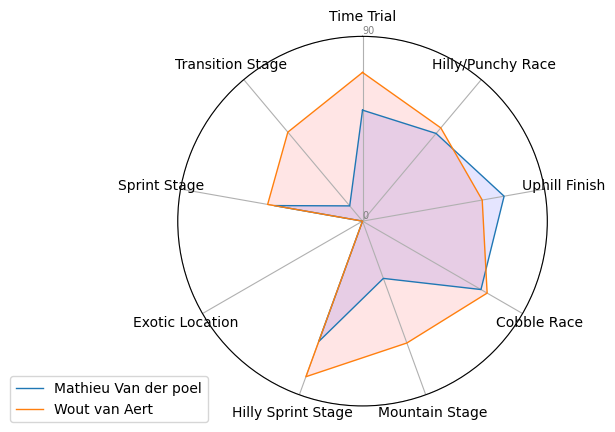

In [125]:
from math import pi

import matplotlib
import matplotlib.pyplot as plt

van_aert = []
vdp = []

for i in range(9):
    try:
        van_aert.append(float(ratings_list_ind[i][ratings_list_ind[i].index=='VAN AERT Wout']["DoublePenaltyRating"]))
    except:
        van_aert.append(0)
    try:
        vdp.append(float(ratings_list_ind[i][ratings_list_ind[i].index=='VAN DER POEL Mathieu']["DoublePenaltyRating"]))
    except:
        vdp.append(0)    

N = 9
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_facecolor('white') 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1],  ['Time Trial', 'Hilly/Punchy Race', 'Uphill Finish', 'Cobble Race', 'Mountain Stage', 'Hilly Sprint Stage' , 'Exotic Location', 'Sprint Stage', 'Transition Stage'])
 
# Draw ylabels
#ax.set_axis_off()

ax.set_rlabel_position(0)
plt.yticks([0,90], ["0", "90"], color="grey", size=7)
plt.ylim(0,90)


# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values = vdp
values += vdp[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Mathieu Van der poel")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values = van_aert
values += van_aert[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Wout van Aert")
ax.fill(angles, values, 'r', alpha=0.1)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Show the graph
plt.show()